## Plot the drift (estimated with DREDGE) across days 

In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams.update({'font.size': 18})

from labdata.schema import *

PROBE_NUM = 0
SHANK_NUM = 0
T_START_SEC = 300
T_END_SEC = 500 # grab spikes from minutes 5 to 10
SHANK_NUMS = [0, 1, 2, 3]

session_offset_sec = T_END_SEC - T_START_SEC

[2024-05-07 18:31:04,134][INFO]: Connecting mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-05-07 18:31:04,478][INFO]: Connected mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [3]:
# query for orientation sessions
ori_session_keys = (Dataset() & 'subject_name = "JC131"' & 'dataset_name LIKE "%ori%%"').fetch('session_name', as_dict=True)
#drop_session_keys = (Dataset() & 'subject_name = "JC131"' & 'dataset_name LIKE "%Droplet%%"').fetch('session_name', as_dict=True)

# query for sessions with the proper probe configuration and sorting parameters
query1 = SpikeSorting * Session * EphysRecording.ProbeSetting() \
    & ori_session_keys \
    & 'parameter_set_num = 6' \
    & 'configuration_id = 3' \
    & f'session_datetime < "2023-11-8"' \
    & 'session_name <> "20231025_183538"' # exclude faulty recording

session_dates = query1.fetch('session_name', order_by='session_datetime')

query = UnitMetrics * SpikeSorting.Unit * Session * EphysRecording.ProbeSetting() \
    & ori_session_keys \
    & 'parameter_set_num = 6' \
    & 'configuration_id = 3' \
    & f'session_datetime < "2023-11-8"' \
    #& f'shank = {SHANK_NUM}'

query & f'session_name = "{session_dates[0]}"' 

#session_dates = session_dates[0:7] # just for testing

*subject_name  *session_name  *dataset_name  *probe_num    *parameter_set *unit_id    num_spikes     depth       position   shank     channel_index  firing_rate    isi_contaminat isi_contaminat amplitude_cuto presence_ratio depth_drift_ra depth_drift_fl spike_amplitud spike_duration trough_time    trough_amplitu fw3m         trough_gradien peak_gradient  peak_time     peak_amplitude polarity     spike_time spike_posi spike_ampl session_dateti experimenter   probe_id       configuration_ sampling_rate 
+------------+ +------------+ +------------+ +-----------+ +------------+ +---------+ +------------+ +---------+ +--------+ +-------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +----------+ +------------+ +------------+ +-----------+ +------------+ +----------+ +--------+ +--------+ +--------+ +------------+ +------------+ +------------+ +------------+ +------------+
JC131          20230724_17534 ephys_g0       0             6              0           7951           2433.82     =BLOB=     3         0              8.2137         0.166735       1.2577         0.000839731    1.0            7.23438        1.47318        306.174        0.409375       -0.0141662     -239.751       0.112678     1529.6         -69.9866       0.395209      66.4233        -1.0         =BLOB=     =BLOB=     =BLOB=     2023-07-24 17: couto          20403312753    3              30000.3       
JC131          20230724_17534 ephys_g0       0             6              1           5069           2287.15     =BLOB=     3         0              5.23498        0.0597017      0.303504       5.10531e-05    1.0            2.3866         0.587608       342.055        0.483383       -0.0094991     -263.786       0.179018     1005.48        -20.6441       0.473884      78.2682        -1.0         =BLOB=     =BLOB=     =BLOB=     2023-07-24 17: couto          20403312753    3              30000.3       
JC131          20230724_17534 ephys_g0       0             6              2           5              nan         =BLOB=     None      None           nan            nan            nan            nan            nan            nan            nan            nan            nan            nan            nan            nan          nan            nan            nan           nan            nan          =BLOB=     =BLOB=     =BLOB=     2023-07-24 17: couto          20403312753    3              30000.3       
JC131          20230724_17534 ephys_g0       0             6              3           69             2771.13     =BLOB=     3         1              0.0742746      0.0            0.0            0.5            0.17           8.10559        8.10559        165.851        0.508719       0.00150203     -112.967       0.216022     103.293        164.307        0.510221      52.8835        -1.0         =BLOB=     =BLOB=     =BLOB=     2023-07-24 17: couto          20403312753    3              30000.3       
JC131          20230724_17534 ephys_g0       0             6              4           5440           2361.6      =BLOB=     3         0              5.62189        nan            2.89876        0.326894       1.0            8.30969        1.55904        193.041        0.402708       -0.00149828    -143.445       0.171351     738.199        -66.3019       0.40121       49.5963        -1.0         =BLOB=     =BLOB=     =BLOB=     2023-07-24 17: couto          20403312753    3              30000.3       
JC131          20230724_17534 ephys_g0       0             6              5           17             nan         =BLOB=     None      None           0.0182521      nan            nan            nan            nan            nan            nan            nan            nan            nan            nan            nan          nan            nan            nan           nan            nan          =BLOB=     =BLOB=     =BLOB=     2023-07-24 17: cout

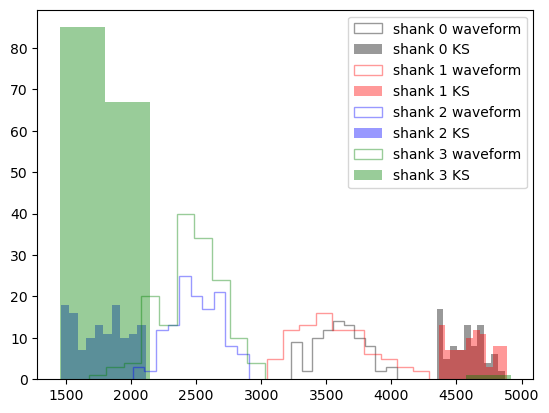

In [4]:
depth, shank, pos = (query & f'session_name = "{session_dates[0]}"').fetch('depth','shank','spike_positions')
cols = ['black', 'red', 'blue', 'green']
for s in range(4):
    d = depth[shank == s]
    plt.hist(d, alpha = .4, label=f'shank {s} waveform', color=cols[s], histtype='step')

    pp = pos[shank == s]
    dd = np.empty_like(pp)
    for i,p in enumerate(pp):
        dd[i] = np.mean(p[:,1])
    plt.hist(dd, alpha = .4, label=f'shank {s} KS', color=cols[s])

plt.legend()
plt.show()

In [5]:
def get_spike_data(session_dates, query, shank_num, t_start_sec, t_end_sec):
    #session_dates = session_dates[0:10] # testing
    session_offset_sec = t_end_sec - t_start_sec
    all_spikes = {}
    all_spikes['amps'] = []
    all_spikes['depths_um'] = []
    all_spikes['times_s'] = []
    session_breaks = []
    for o,d in enumerate(tqdm(session_dates)):
        dat = (query & dict(session_name=d, shank=shank_num)).fetch('spike_amplitudes','spike_times','spike_positions', as_dict=True)
        fs = (EphysRecording.ProbeSetting() & f'session_name = "{d}"' & f'probe_num = {PROBE_NUM}').fetch1('sampling_rate')
        for i in range(len(dat)): # loop over units
            #plt.hist(dat[i]['spike_positions'][:,0]) # plot for spike positions
            timeinds2grab = np.logical_and(dat[i]['spike_times'] > t_start_sec * fs, dat[i]['spike_times'] < t_end_sec * fs)
            #shankinds2grab = np.logical_and(dat[i]['spike_positions'][:,0] > 0, dat[i]['spike_positions'][:,0] < 150) #FIXME: this is a temp fix until waveform positions are fixed
            #shankinds2grab = np.logical_and(dat[i]['spike_positions'][:,0] > 500, dat[i]['spike_positions'][:,0] < 650) #FIXME: this is a temp fix until waveform positions are fixed
            if shank_num in (0,1):
                depthinds2grab = dat[i]['spike_positions'][:,1] < 4790
            elif shank_num in (2,3):
                depthinds2grab = dat[i]['spike_positions'][:,1] < 3500
            #inds2grab = np.logical_and.reduce([timeinds2grab, shankinds2grab, depthinds2grab])
            inds2grab = np.logical_and(timeinds2grab, depthinds2grab)
            if np.sum(inds2grab) == 0:
                continue
            all_spikes['amps'] = np.concatenate([all_spikes['amps'], dat[i]['spike_amplitudes'][inds2grab]])
            all_spikes['depths_um'] = np.concatenate([all_spikes['depths_um'], dat[i]['spike_positions'][inds2grab,1]])
            spike_times_s = dat[i]['spike_times'][inds2grab] / fs
            all_spikes['times_s'] = np.concatenate([all_spikes['times_s'], spike_times_s + session_offset_sec*o - t_start_sec])
        session_breaks.append(session_offset_sec*o)
    session_breaks = np.array(session_breaks[1:])
    return all_spikes, session_breaks


In [6]:
sys.path.append('/home/joao/lib/dredge/dredge-python/')
from dredge.dredge_ap import register

shank_motion_estimates = []
shank_spikes = []
for s in SHANK_NUMS:
    all_spikes_on_shank, session_breaks = get_spike_data(session_dates, query, s, T_START_SEC, T_END_SEC)
    shank_spikes.append(all_spikes_on_shank)

    motion_est, _ = register(**all_spikes_on_shank)
    shank_motion_estimates.append(motion_est)

100%|██████████| 76/76 [08:29<00:00,  6.70s/it]


Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

Weights:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 76/76 [04:34<00:00,  3.62s/it]


Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

Weights:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 76/76 [11:31<00:00,  9.09s/it]


Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

Weights:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 76/76 [11:29<00:00,  9.07s/it]


Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

Weights:   0%|          | 0/1 [00:00<?, ?it/s]

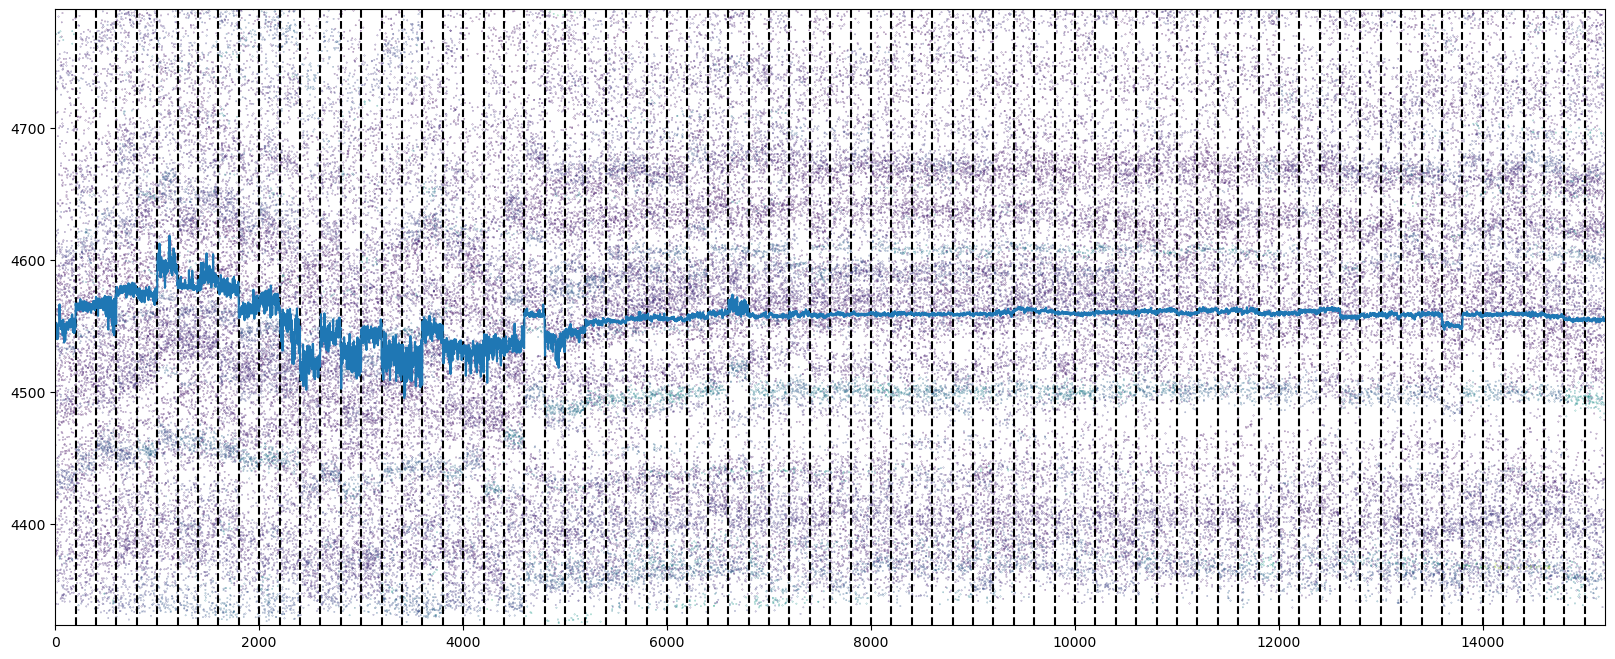

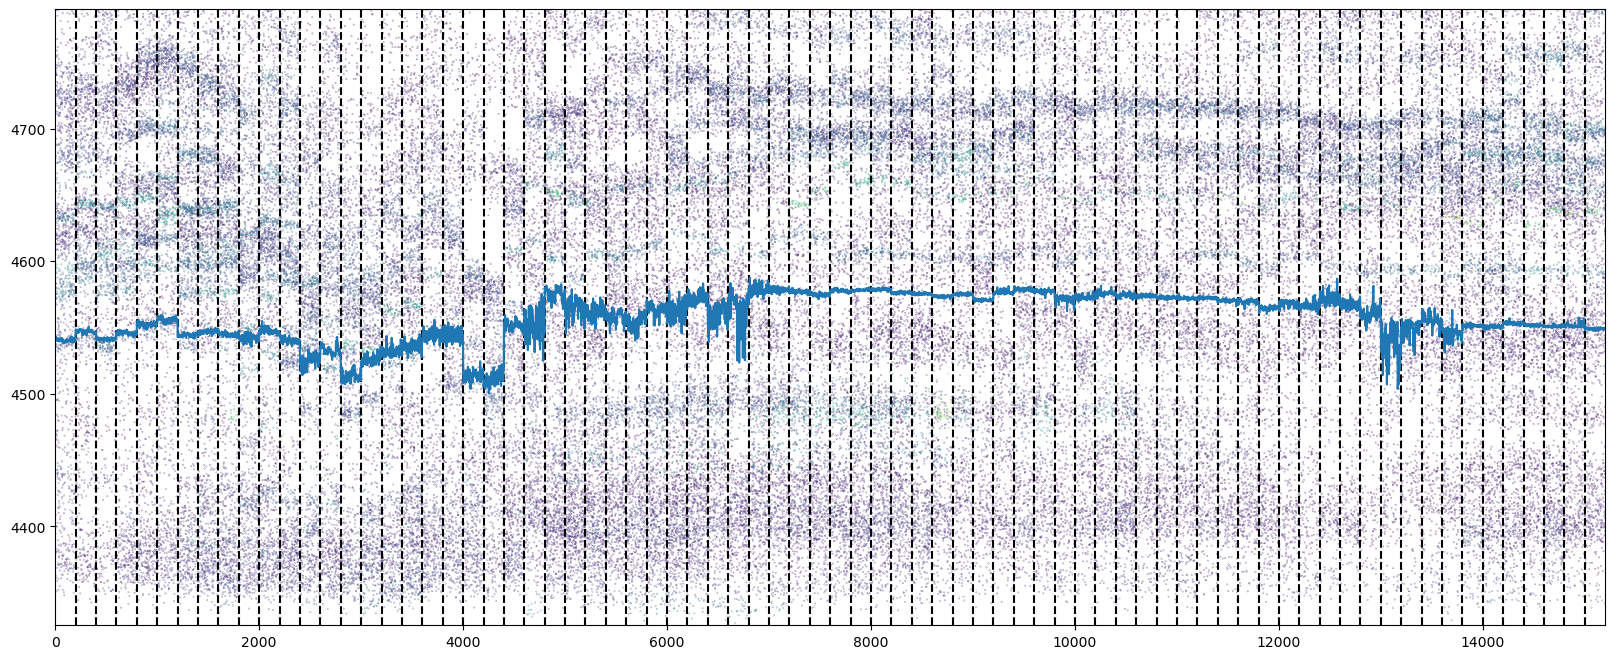

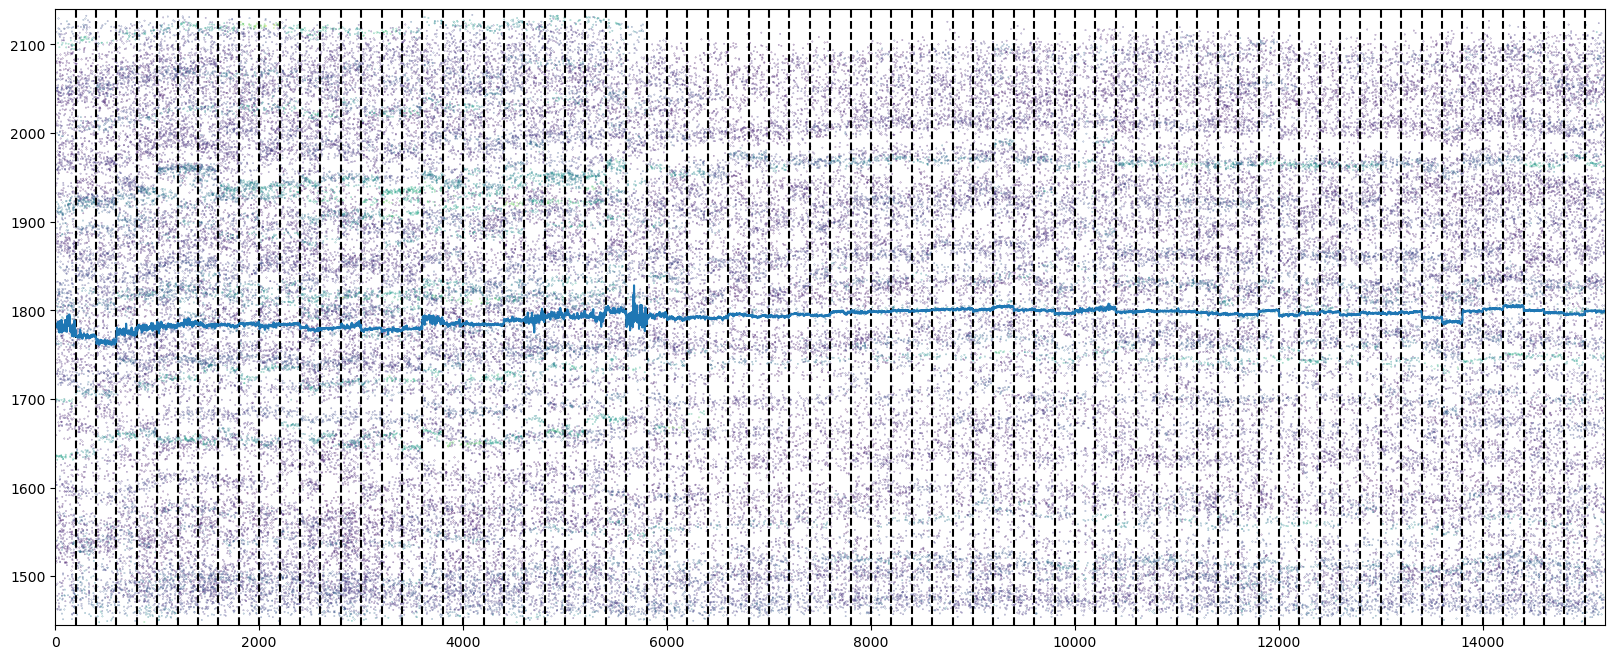

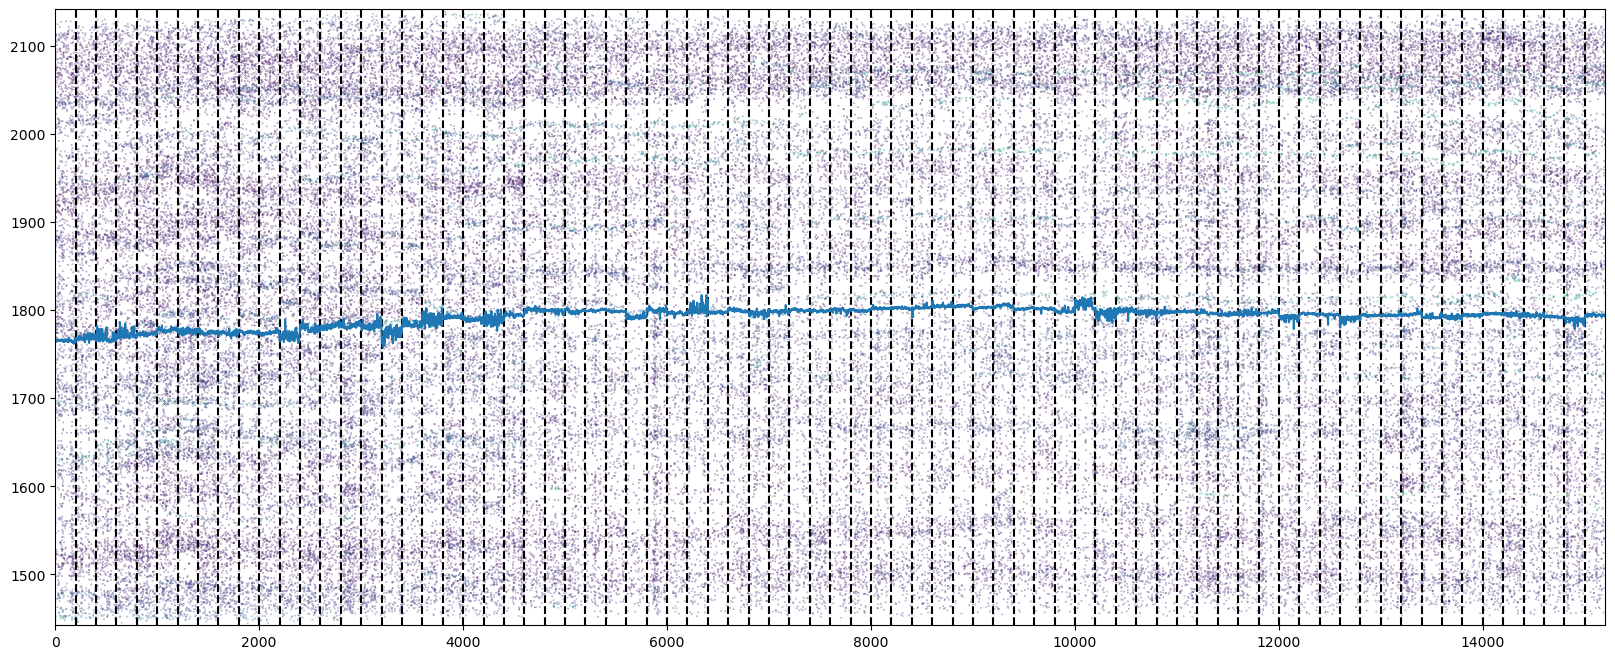

In [7]:
from spks.viz import plot_drift_raster

for i,shank in enumerate(SHANK_NUMS):
    all_spikes = shank_spikes[i]
    plt.figure(figsize=(20,8))
    plot_drift_raster(all_spikes['times_s'], all_spikes['depths_um'], all_spikes['amps'], rasterized=True)
    plt.vlines(session_breaks, *plt.gca().get_ylim(), linestyles='--', colors='black')

    motion_est = shank_motion_estimates[i]
    offset = np.mean(plt.ylim())
    plt.plot(offset + motion_est.displacement.T)
    plt.show()

In [14]:
lims = np.concatenate([np.array([0]), session_breaks])

def compute_intersession_drift(motion_est, lims):
    mot = []
    for start, end in zip(lims[:-1], lims[1:]):
        mot.append(np.mean(motion_est.displacement[start:end])) # mean position per session

    diffs = np.diff(mot)
    return diffs


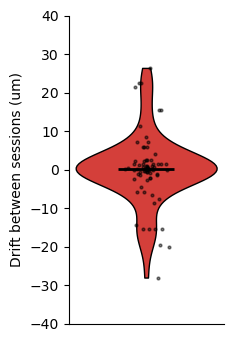

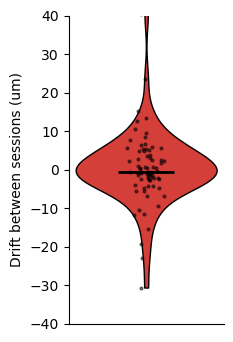

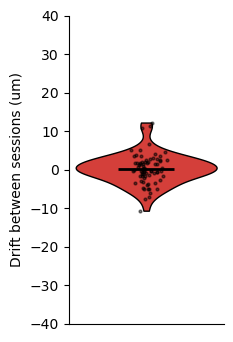

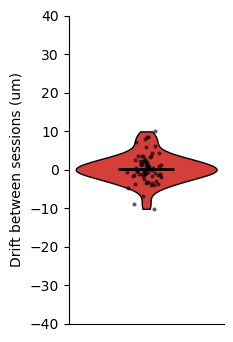

In [48]:
intersession_drifts = [compute_intersession_drift(m, lims) for m in shank_motion_estimates]
for drift in intersession_drifts:
    x = 0
    scatter_positions = np.random.normal(x, .03, len(drift))
    fig, ax = plt.subplots(figsize=(2,4))
    parts = plt.violinplot([drift], [x], showextrema=False, showmedians=False)
    plt.scatter(scatter_positions, drift, color='black', s=4, alpha=.5)
    quartile1, median, quartile3 = np.percentile(drift, [25, 50, 75])
    plt.hlines(median, x - .1, x + .1, color='black', linestyle='-', lw=2)
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    plt.ylim(-40, 40)
    plt.ylabel('Drift between sessions (um)')
    plt.xlabel('')
    plt.xticks([])
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.show()

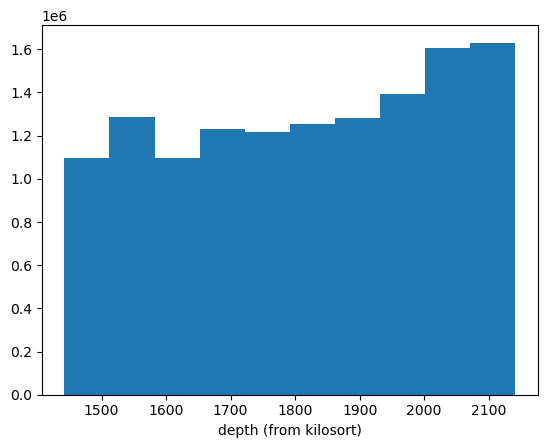

[2024-05-08 10:22:40,664][WARNING]: MySQL server has gone away. Reconnecting to the server.


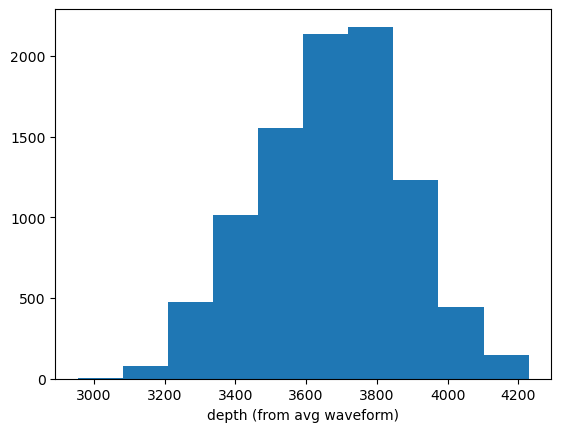

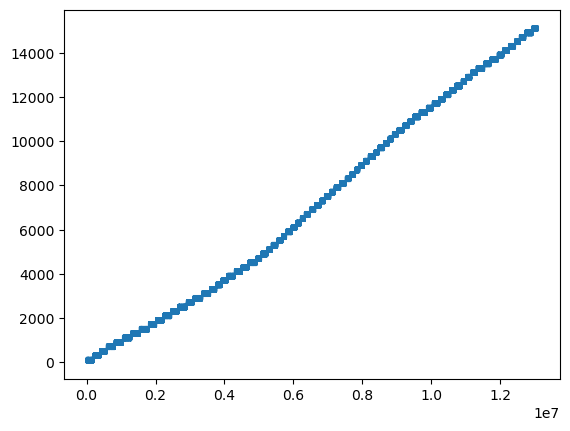

In [12]:
plt.hist(all_spikes['depths_um'])
plt.xlabel('depth (from kilosort)')
plt.show()
plt.hist((query & 'shank = 0').fetch('depth'))
plt.xlabel('depth (from avg waveform)')
plt.show()
plt.plot(all_spikes['times_s'])

In [10]:
xy = (ProbeConfiguration() & 'configuration_id = 3' & 'probe_id = 20403312753').fetch('channel_coords')[0]

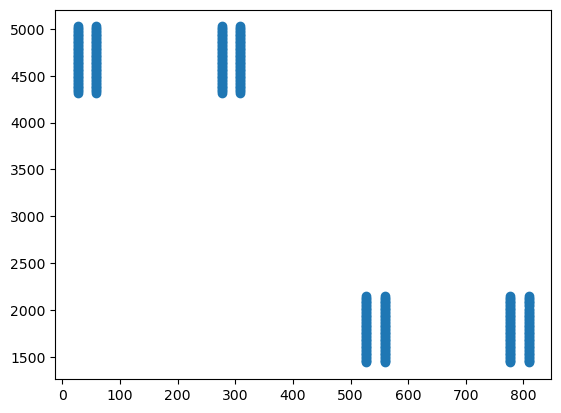

In [11]:
plt.scatter(*xy.T)